In [1]:
!pip install -q datasets

In [2]:
from transformers import AutoTokenizer
import torch.nn as nn
from torch.utils.data import DataLoader
import torch

# #extract pretrained tokenizer from huggingface
# tokenizer=AutoTokenizer.from_pretrained('gpt2')
# tokenizer

device='cuda' if torch.cuda.is_available() else 'cpu'

## Load the English to Nepali Translation Dataset From Huggingface

In [3]:
from datasets import load_dataset

ds = load_dataset("CohleM/english-to-nepali")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
ds['train']

Dataset({
    features: ['en', 'ne'],
    num_rows: 177334
})

## Make Train Dataloader

In [236]:

# making train dataloader
train_dataloader=DataLoader(ds['train'],batch_size=128,shuffle=False)
train_dataloader

In [237]:
# extracting a single batch from the traindataloader
for data in train_dataloader:
  print(data)
  break

{'en': ['Technical committees will be attached to each ministry.', 'An Administrative Panel will examine and advise the Cabinet Development Committee regarding all proposals having to do with terms of employment or administrative rules and regulations applicable to personnel engaged in Five –Year Plan operations, procedures or delegations of authority.', 'A special committee will be appointed to advise on the coordination of foreign aid.', 'In districts where development is more intensive, the Badahakims  will be assisted by District Development Officer and staffs of technical advisors appointed by executive agencies of the central Government.', "About three fourths of Nepal's 15 crores per year imports from India consist of textiles, cigarettes, sugar, petrol, etc., on which products excise taxes within India average about 20 per cent.", 'As indicated above, the entire Five-Year Plan as projected calls for an outlay of approximately 33 crore rupees.', 'Full execution of the Plan would

In [238]:
# making a dictionary of tokens for both english and nepali language

# extract every sentence from the dataloader and tokenize it one by one.. not a good method. need to add padding manually by
# deriving the maximum length of tokens for each batch and after that add padding to make the same length.
# padding is needed beacuse we are making the batch. otherwise it is not needed in RNN.

# for data in train_dataloader:

#     for sentence in data['en']:
#         t_dict['en'].append(tokenizer.encode(sentence))

#     for sentence in data['ne']:
#         t_dict['ne'].append(tokenizer.encode(sentence))

#     break


In [239]:
# gpt2 doesnt have special tokens to adding a padding token and start of sentence token
# tokenizer.add_special_tokens({'pad_token':'<pad>'})
# tokenizer.add_special_tokens({'bos_token':'<sos>'})

In [240]:
# for data in train_dataloader:
#     t_dict['en']=tokenizer(data['en'],padding=True)['input_ids']
#     t_dict['ne']=tokenizer(data['ne'],padding=True)['input_ids']
#     print(t_dict['en'])
#     break

## Building Custom Tokenizer

In [241]:
class Toke():
    def __init__(self,text: str,final_vocab_size: int):
        ''' text: (string) a chunk of text to train the tokenizer
            final_vocab_size: (int) maximum number of tokens in the vocab
        '''
        self.final_vocab_size=final_vocab_size
        self.tokens = text.encode("utf-8") # raw bytes
        self.tokens = list(map(int, self.tokens)) # convert to a list of integers in range 0..255 for convenience
        self.ids = list(self.tokens) # copy so we don't destroy the original list
        self.merges = {} # (int, int) -> int
        self.vocab={idx: bytes([idx]) for idx in range(256)}

    def get_stats(self,ids):
        self.counts={}
        for pair in zip(ids, ids[1:]):
            self.counts[pair] = self.counts.get(pair, 0) + 1
        return self.counts

    def merge(self,ids, pair, idx):
        i = 0
        self.newids=[]
        while i < len(ids):
            if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
                self.newids.append(idx)
                i += 2
            else:
                self.newids.append(ids[i])
                i += 1
        return self.newids

    # make the vocab reamining
    def create_final_vocab(self):
        ''' creates final vocabulary dictionary using BPE '''
        # create the merge dictionary using BPE algo
        for i in range(self.final_vocab_size-256):
            stats = self.get_stats(self.ids)
            pair = max(stats, key=stats.get)
            idx = 256 + i
            print(f"merging {pair} into a new token {idx}")
            self.ids = self.merge(self.ids, pair, idx)
            self.merges[pair] = idx

        # create final vocab
        for (p0, p1), idx in self.merges.items():
            self.vocab[idx] = self.vocab[p0] + self.vocab[p1]


    def encode(self,text):
        '''given a string, return list of integers (the tokens)'''
        tokens = list(text.encode("utf-8"))
        while len(tokens) >= 2:
            stats = self.get_stats(tokens)
            pair = min(stats, key=lambda p: self.merges.get(p, float("inf")))
            if pair not in self.merges:
                break # nothing else can be merged
            idx = self.merges[pair]
            tokens = self.merge(tokens, pair, idx)
        return tokens

    def decode(self,ids):
        '''given ids (list of integers), return Python string'''
        tokens = b"".join(self.vocab[idx] for idx in ids)
        text = tokens.decode("utf-8", errors="replace")
        return text



### Use Already Trained Custom Tokenizer
  1. Load the save tokenizer from `custom_tokenizer.pt` file

In [242]:
#Load the saved tokenizer
otoke=torch.load('/content/custom_tokenizer.pt')


# to train the tokenizer
# otoke=Toke(text="<your text here> ",final_vocab_size=1000)
# otoke.create_final_vocab()

# adding start of sentence token in vocab
otoke.vocab[1000]=b'<sos>'
otoke.vocab[1001]=b'<pad>'
otoke.vocab[1002]=b'<eos>'

## Build Encoder for Langugage Translation Task

In [264]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding=nn.Embedding(1003,128,padding_idx=1001)
        self.rnn=nn.GRU(128,hidden_size=32,batch_first=True)


    def forward(self,x,hidden=None):
        x=self.embedding(x)
        x,hidden=self.rnn(x,hidden)
        return x,hidden


In [265]:
model_rnn=Encoder()
model_rnn.to(device)

Encoder(
  (embedding): Embedding(1003, 128, padding_idx=1001)
  (rnn): GRU(128, 32, batch_first=True)
)

In [245]:
# enc_out,enc_hid=model_rnn(torch.tensor(otoke.encode(data['en'][0])).unsqueeze(0))

In [246]:
# enc_out.shape,enc_hid.shape

In [247]:
# torch.tensor(t_dict['en']).shape

## Build Decoder for Language Translation Task

In [266]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.embedding=nn.Embedding(1003,128,padding_idx=1001)
        self.rnn=nn.GRU(128,hidden_size=32,batch_first=True)
        self.linear=nn.Linear(32,1003)


    def forward(self,encoder_outputs,encoder_hidden,target_tensor=None):

        batch_size=encoder_outputs.shape[0]
        decoder_input=torch.empty(batch_size,1,dtype=torch.long,device='cuda').fill_(torch.tensor(1000))#(torch.tensor(tokenizer.encode(tokenizer.bos_token)[0]))
        decoder_hidden=encoder_hidden
        decoder_outputs=[]

        for i in range(target_tensor.shape[1]):
        # for i in range(50):
          decoder_out,decoder_hidden=self.forward_step(decoder_input,decoder_hidden)
          decoder_outputs.append(decoder_out)


          if target_tensor is not None:
              if (target_tensor[:,i]).tolist().count(1001)/len(target_tensor[:,i])>0.75:
                break
                # pass
              decoder_input=target_tensor[:,i].unsqueeze(1)
          else:
              _, topi = decoder_out.topk(1)
              decoder_input = topi.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = nn.functional.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden

    def forward_step(self,input,hidden):
        out=self.embedding(input)
        out,hidden=self.rnn(out,hidden)
        out=self.linear(out)
        return out,hidden



In [267]:
dec_rnn=Decoder()
dec_rnn.to(device)

Decoder(
  (embedding): Embedding(1003, 128, padding_idx=1001)
  (rnn): GRU(128, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=1003, bias=True)
)

In [250]:
# dec_out,dec_hidden=dec_rnn(encoder_outputs=enc_out.to(device),encoder_hidden=enc_hid.to(device),target_tensor=torch.tensor(t_dict['ne']).to(device))
# dec_out.shape,dec_hidden.shape


In [251]:
# outty=dec_out.argmax(dim=-1)
# outty.shape

In [252]:
# tokenizer.decode(outty[3])

In [253]:
# len(train_dataloader)

## Train the Language Translation Model

In [280]:
# model_rnn=torch.load('/content/Lencoder.pt',map_location=torch.device(device))
# dec_rnn=torch.load('/content/Ldecoder.pt',map_location=torch.device(device))

# optimizers for encoder and decoder
encoder_optimizer=torch.optim.Adam(model_rnn.parameters(),lr=0.1)
decoder_optimizer=torch.optim.Adam(dec_rnn.parameters(),lr=0.1)

# loss function
criterion=nn.NLLLoss()

In [284]:
train_loss=[]

In [285]:
for epoch in range(100):
  total_loss = 0
  num_example=0
  for data in train_dataloader:

    t_dict={'en':[],
            'ne':[]
            }

    num_example+=1

    # encoding every sentence in a batch individually
    for lang in ['en','ne']:
        for sentence in data[lang]:
            t_dict[lang].append(otoke.encode(sentence))
            t_dict[lang][-1].append(1002) #eos token is 1002

    # padding the whole batch according to maximum length

    # finding maximum sentence length for each batch
    for lang in ['en','ne']:
        sen_length=[]
        for sen in t_dict[lang]:
            sen_length.append(len(sen))

        # add zero padding to all token if not of same length(max length)
        for sen in t_dict[lang]:
            for i in range(len(sen),max(sen_length)):
                sen.append(1001) #pad token is 1001


  #   t_dict['en']=torch.tensor(otoke.encode(data['en'][0])).unsqueeze(0)
  #   t_dict['ne']=torch.tensor(otoke.encode(data['ne'][0])).unsqueeze(0)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    enc_out,enc_hid=model_rnn(torch.tensor(t_dict['en']).to(device))
    dec_out,dec_hidden=dec_rnn(encoder_outputs=enc_out,encoder_hidden=enc_hid,target_tensor=torch.tensor(t_dict['ne']).to(device))

    loss = criterion(
        dec_out.view(-1, dec_out.size(-1)),
        (torch.tensor(t_dict['ne'])[:,:dec_out.shape[1]]).to(device).view(-1)
    )
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    total_loss += loss.item()
    # print the output if
    if(loss.item()<0.5):
      print(f"\nEnglish: {otoke.decode((t_dict['en'])[1])}")
      print(f"True: {otoke.decode((t_dict['ne'])[1])}")
      print(f"Predicted: {otoke.decode(dec_out.argmax(dim=-1).tolist()[1])}")

    if num_example>1:
      break
  train_loss.append(total_loss/num_example)
  print(f"Epoch: {epoch+1}  Loss: {total_loss/num_example}")
  if (epoch+1)%30 ==0:
    torch.save(model_rnn,f'/content/drive/MyDrive/resource/gencoder_{epoch+1}.pt')
    torch.save(dec_rnn,f'/content/drive/MyDrive/resource/gdecoder_{epoch+1}.pt')
    torch.save(train_loss,f'/content/drive/MyDrive/resource/gtrain_loss_{epoch+1}.pt')


Epoch: 1  Loss: 1.7872253060340881
Epoch: 2  Loss: 1.7653364539146423
Epoch: 3  Loss: 1.750616729259491
Epoch: 4  Loss: 1.7364986538887024
Epoch: 5  Loss: 1.7274382710456848
Epoch: 6  Loss: 1.7164854407310486
Epoch: 7  Loss: 1.709526777267456
Epoch: 8  Loss: 1.701742172241211
Epoch: 9  Loss: 1.693630039691925
Epoch: 10  Loss: 1.68800288438797
Epoch: 11  Loss: 1.6859700083732605
Epoch: 12  Loss: 1.6860649585723877
Epoch: 13  Loss: 1.676839530467987
Epoch: 14  Loss: 1.6745494604110718
Epoch: 15  Loss: 1.676776647567749
Epoch: 16  Loss: 1.6669675707817078
Epoch: 17  Loss: 1.6618999242782593
Epoch: 18  Loss: 1.6581740379333496
Epoch: 19  Loss: 1.6559851169586182
Epoch: 20  Loss: 1.649311602115631
Epoch: 21  Loss: 1.6468201279640198
Epoch: 22  Loss: 1.6452834606170654
Epoch: 23  Loss: 1.642846167087555
Epoch: 24  Loss: 1.640954077243805
Epoch: 25  Loss: 1.6415133476257324
Epoch: 26  Loss: 1.6405166983604431
Epoch: 27  Loss: 1.63418048620224
Epoch: 28  Loss: 1.6393553018569946
Epoch: 29  Los

In [286]:
dec_out.shape

torch.Size([128, 92, 1003])

In [288]:
print(otoke.decode(t_dict['en'][1]))
print("\n")
print(otoke.decode(t_dict['ne'][1]))
print("\n")
print(otoke.decode(dec_out.argmax(dim=-1).tolist()[1]))

The First Five Year Plan, prepared by the Board, covered the 1956-61 periods.<eos><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


२०१३ सालमा गठन भएको मण्डलले तर्जुमा गरेको प्रथम पंञ्चवर्षीय योजना सोही वर्षदेखि लागू गरी २०१७-१८ मा समाप्त भयो<eos><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

## Loss Curves

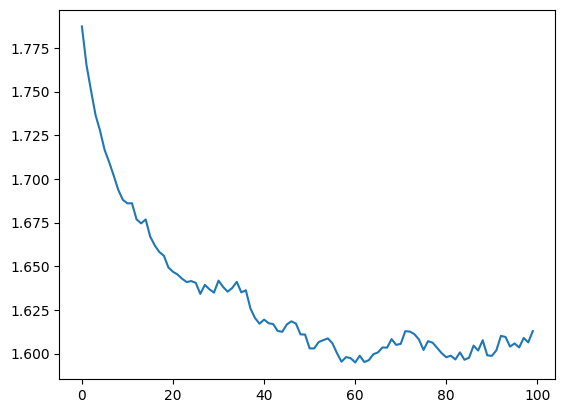

In [289]:
import matplotlib.pyplot as plt

plt.plot(train_loss)